In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [6]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm, # not really useful but okay
             'surf_units': u.micron,
             'ring_width': 5,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm}

folder_coat = 'zygo_data/oaps/oap_coated/'
coat_labels =  ('0', '1', '2', '3', '4', '5_sn1', '5_sn2', '5_sn3')
ntot = len(coat_labels)

oap=[]
flat_norm = np.zeros((ntot, opt_parms['ovs']*opt_parms['ovs']))
flat_var = np.zeros((ntot))
for n in range(0,ntot):
    # Write filename
    surf_data_loc = folder_coat+'oap{0}_centered_{1}CA'.format(coat_labels[n], str(opt_parms['ca']))
    n_oap = 'n{0}'.format(coat_labels[n])
    
    # create the object
    t_oap = psd.surfPSD(surf_name = n_oap)
    
    # open the files
    t_oap.open_surf(fileloc=surf_data_loc+'_surf.fits', surf_units=opt_parms['surf_units'])
    t_oap.open_mask(fileloc=surf_data_loc+'_mask.fits')

    # calculate the PSD
    t_oap.calc_psd(oversamp = opt_parms['ovs'], kmid_ll=opt_parms['kmid_ll'], 
                   khigh_ll=opt_parms['khigh_ll'],)
    if n==2: # this one is a little ridiculous
        print('psd for {0} needs masking to eliminate sine wave blips'.format(n_oap))
        n2_mask_centers = [(3107, 1922), (990, 2175)]
        n2_radius = [28, 28]
        t_oap.mask_psd(n2_mask_centers, n2_radius)
        t_oap.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                           pwr_opt=t_oap.psd_cal)
    
    # save the PSD file for future opening
    t_oap.write_psd_file(filename=surf_data_loc+'_PSD.fits', psd_data=t_oap.psd_cal,
                         single_precision=False)
    
    # calculate the radial profile
    t_oap.calc_psd_radial(ring_width=5)
    print('PSD and radial profile for {0} complete\n'.format(n_oap))
    
    oap.append(t_oap)
    flat_norm[n] = t_oap.psd_norm.reshape(opt_parms['ovs']*opt_parms['ovs'])
    flat_var[n] = t_oap.var.value
    
print('All OAP PSD complete')

PSD and radial profile for n0 complete

PSD and radial profile for n1 complete

psd for n2 needs masking to eliminate sine wave blips
PSD and radial profile for n2 complete

PSD and radial profile for n3 complete

PSD and radial profile for n4 complete

PSD and radial profile for n5_sn1 complete

PSD and radial profile for n5_sn2 complete

PSD and radial profile for n5_sn3 complete

All OAP PSD complete
CPU times: user 4min 55s, sys: 1min 49s, total: 6min 44s
Wall time: 6min 32s


In [7]:
# calculate the average OAP PSD
norm_psd_avg = np.mean(flat_norm, axis=0).reshape(opt_parms['ovs'], 
                                                  opt_parms['ovs'])*oap[0].psd_norm.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*oap[0].var.unit
cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by making its own object
avg_psd = psd.surfPSD(surf_name='oap_avg')
avg_psd.load_psd(psd_data=cal_psd_avg, psd_type='cal', var=var_avg)
avg_psd.load_psd_parameters(oversamp=oap[0].oversamp,
                            diam_ca=oap[0].diam_ca,
                            npix_diam=oap[0].npix_diam,
                            wavelen=oap[0].wavelen)
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'], 
                     pwr_opt=avg_psd.psd_cal)
avg_psd.write_psd_file(filename=folder_coat+'oap_avgPSD_centered_{0}CA'.format(str(opt_parms['ca'])),
                       psd_data = avg_psd.psd_cal,
                      single_precision=False)
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for all dust masked in averaged surface complete.')

PSD and radial profile for all dust masked in averaged surface complete.


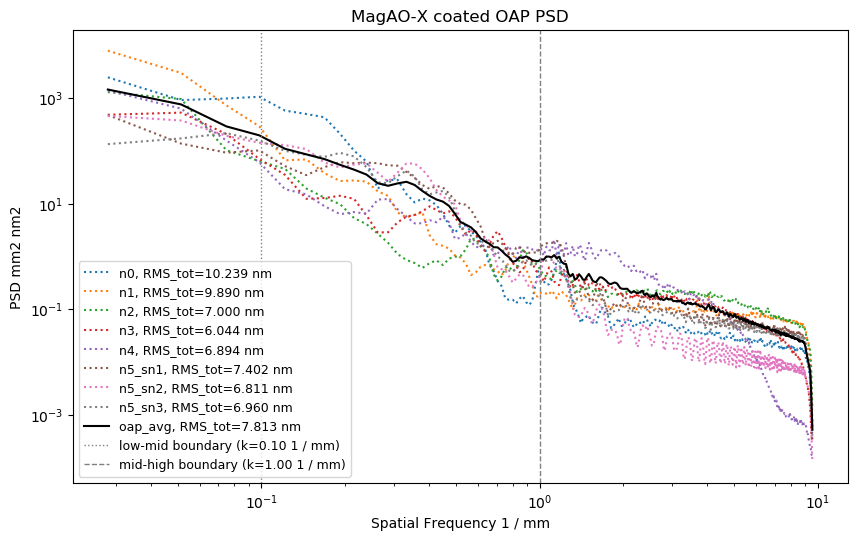

In [19]:
plt.figure(figsize=[10,6],dpi=100)
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_tot={1:.3f}'.format(obj.surf_name, obj.rms_tot))
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_tot={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_tot))
plt.axvline(x=opt_parms['kmid_ll'].value, color='grey', ls=':', label='low-mid boundary (k={0:.2f})'.format(opt_parms['kmid_ll']), linewidth=1)
plt.axvline(x=opt_parms['khigh_ll'].value, color='grey', ls='--', label='mid-high boundary (k={0:.2f})'.format(opt_parms['khigh_ll']), linewidth=1)
plt.xlabel('Spatial Frequency {0}'.format(oap[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(oap[0].psd_radial_cal.unit))
plt.title('MagAO-X coated OAP PSD')
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))


### Calculate the RMS at low, mid, high spatial frequency bands.
Verify that manufacturer met specs.

In [13]:
# Evaluate the rms at low, mid, high spatial frequency 
klow_rms_target = 7.5*u.nm
kmid_rms_target = 10.2*u.nm
khigh_rms_target = 5.2*u.nm

# Evaluate the rms at low, mid, high spatial frequency 
print('RMS calculations')
print('{0:>7} | {1:^9.4} | {2:^10.4} | {3:^9.4} | {4:^9.4}'.format('optic', 'low', 'mid', 'high', 'tot'))
print('{0:>7} | {1:.4f} | {2:2.4f} | {3:.4f} |'.format('tgt', klow_rms_target, kmid_rms_target, khigh_rms_target))
for no in range(0, ntot):
    print('{0:>7} | {1:.4f} | {2:7.4f} | {3:.4f} | {4:.4f}'.format(oap[no].surf_name, oap[no].rms_l, oap[no].rms_m, oap[no].rms_h, oap[no].rms_tot))

RMS calculations
  optic |    low    |    mid     |   high    |    tot   
    tgt | 7.5000 nm | 10.2000 nm | 5.2000 nm |
     n0 | 5.8538 nm |  7.9023 nm | 2.8488 nm | 10.2386 nm
     n1 | 8.0930 nm |  3.5026 nm | 4.4766 nm | 9.8896 nm
     n2 | 3.7902 nm |  2.3665 nm | 5.3881 nm | 6.9998 nm
     n3 | 2.9920 nm |  3.1610 nm | 4.1942 nm | 6.0444 nm
     n4 | 3.5548 nm |  2.9776 nm | 5.1014 nm | 6.8940 nm
 n5_sn1 | 2.1368 nm |  5.7344 nm | 4.1643 nm | 7.4021 nm
 n5_sn2 | 2.7968 nm |  5.7863 nm | 2.2547 nm | 6.8108 nm
 n5_sn3 | 2.3190 nm |  5.4322 nm | 3.6816 nm | 6.9599 nm
